In [1]:
!pip install conllu

Import  library

In [2]:

import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from conllu import parse
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
# from conllu import parse

set gpu or cpu

In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
device

device(type='cpu')

file names

In [4]:
trainfilePath="en_atis-ud-train.conllu"
validationfilePath="en_atis-ud-dev.conllu"
testfilePayh="en_atis-ud-test.conllu"
word_max_len=50

Load data

In [5]:
warnings.filterwarnings("ignore")
torch.manual_seed(1)
with open(trainfilePath) as f:
    train_data = parse(f.read())
with open(validationfilePath) as f:
    dev_data = parse(f.read())
with open(testfilePayh) as f:
    test_data = parse(f.read())

Prepare data

In [6]:
# train_data
def prepare_datasets(dataset):
    # dict1={}
    mod_data = []
    for idx in range(len(dataset)):
        tempword = []
        temptag = []
        for jdx in range(len(dataset[idx])):
            tempword.append(dataset[idx][jdx]["form"])
            temptag.append(dataset[idx][jdx]["upos"])



        mod_data.append([tempword, temptag])
    return mod_data
mod_train_data = prepare_datasets(train_data)
mod_dev_data = prepare_datasets(dev_data)
mod_test_data = prepare_datasets(test_data)


Number of sentense in each catogery

In [7]:
print(f"Number of training examples: {len(mod_train_data)}")
print(f"Number of validation examples: {len(mod_dev_data)}")
print(f"Number of testing examples: {len(mod_test_data)}")

Number of training examples: 4274
Number of validation examples: 572
Number of testing examples: 586


create vocab for train data

In [8]:
words_list = [sublist[0] for sublist in mod_train_data]
word_vocab = torchtext.vocab.build_vocab_from_iterator(words_list, min_freq=2)
word_vocab.insert_token("<unk>", 0)
word_vocab.set_default_index(word_vocab["<unk>"])

tags_list = [sublist[1] for sublist in mod_train_data]
tag_vocab = torchtext.vocab.build_vocab_from_iterator(tags_list)

itos_mapping = tag_vocab.get_stoi()

print(itos_mapping)
print(f"Unique words: {len(word_vocab)}")
print(f"Unique tags: {len(tag_vocab)}")

{'PART': 11, 'ADV': 10, 'CCONJ': 9, 'INTJ': 12, 'AUX': 6, 'VERB': 3, 'NUM': 8, 'NOUN': 2, 'ADJ': 7, 'ADP': 1, 'PRON': 5, 'DET': 4, 'PROPN': 0}
Unique words: 601
Unique tags: 13


Padding

In [9]:
X_train = [sublist[0] for sublist in mod_train_data]
Y_train=[sublist[1] for sublist in mod_train_data]


X_valid = [sublist[0] for sublist in mod_dev_data]
Y_valid=[sublist[1] for sublist in mod_dev_data]



X_test = [sublist[0] for sublist in mod_test_data]
Y_test=[sublist[1] for sublist in mod_test_data]






def replace_word_in_lists(list_of_lists, X_list_of_list, word_to_replace):
    updated_list_of_lists = []
    updated_X_list_of_list = []

    for sub_list, X_sub_list in zip(list_of_lists, X_list_of_list):
        updated_sub_list = []
        updated_sub_list_X = []

        for word, X_word in zip(sub_list, X_sub_list):
            if word == word_to_replace:
                # Skip adding word_to_replace and its corresponding element
                continue

            updated_sub_list.append(word)
            updated_sub_list_X.append(X_word)

        updated_list_of_lists.append(updated_sub_list)
        updated_X_list_of_list.append(updated_sub_list_X)

    return updated_list_of_lists, updated_X_list_of_list

Y_valid,X_valid=replace_word_in_lists(Y_valid,X_valid,'SYM',)





In [10]:
def sequence_to_idx(X, ix):
  encoded_X=[]
  for sent in X:
    ans=[]


    for word in sent:
      try:
        ans.append(ix[word])
      except KeyError:
        ans.append(0)

    encoded_X.append(ans)
  return encoded_X
def sequence_to_idx_user(X, ix):
  encoded_X=[]

  for word in X:
    try:
      encoded_X.append(ix[word])
    except KeyError:
      encoded_X.append(0)
  return encoded_X

In [11]:
X_train_encoded=sequence_to_idx(X_train,word_vocab)
Y_train_encoded=sequence_to_idx(Y_train,tag_vocab)



X_valid_encoded=sequence_to_idx(X_valid,word_vocab)
Y_valid_encoded=sequence_to_idx(Y_valid,tag_vocab)



X_test_encoded=sequence_to_idx(X_test,word_vocab)
Y_test_encoded=sequence_to_idx(Y_test,tag_vocab)


One-hot-encodeing

In [12]:
X_train_final = X_train_encoded
Y_train_final = Y_train_encoded


X_valid_final = X_valid_encoded
Y_valid_final = Y_valid_encoded


X_test_final = X_test_encoded
Y_test_final = Y_test_encoded


In [16]:
input_dim = 64
output_dim = 30
hidden_dim = 64
DROPOUT=0.5
lr=0.005
num_epochs = 13
Bidirectional=True
Layer_number=2

Model

In [17]:
class LSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, word_hidden_dim, vocab_size, tagset_size, dropout_fac):
        super(LSTMTagger, self).__init__()
        self.word_hidden_dim = word_hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, word_embedding_dim)
        self.lstm = nn.LSTM(word_embedding_dim, word_hidden_dim, num_layers=Layer_number, bidirectional=Bidirectional)

        self.hidden2tag = nn.Linear(word_hidden_dim * 2, tagset_size)

        self.dropout = nn.Dropout(dropout_fac)

    def forward(self, sentence):
        embeds = self.dropout(self.word_embeddings(sentence))
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores



In [18]:

model = LSTMTagger(input_dim, hidden_dim, len(word_vocab), len(tag_vocab), DROPOUT)


loss_function = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr)
# model.load_state_dict(torch.load("lstm_model.pt"))
# model.eval()



In [19]:
def calc_correct(targets_val,indices_val):
  ans=0.0
  for i,j in zip(targets_val,indices_val):
    if i==j:
      ans=ans+1.0
  ans=ans/len(indices_val)
  return ans


In [20]:
def train_model(model,loss_function,optimizer,num_epochs,X_train_final,Y_train_final,X_valid_final,Y_valid_final):
  train_accuracy=[]
  train_loss=[]
  valid_accuracy=[]
  valid_loss=[]
  epoch_v=[]


  for epoch in range(num_epochs):
    epoch_v.append(epoch+1)
    model.train()
    acc=0
    loss=0
    v_loss=0
    v_acc=0
    for input, targets in zip(X_train_final,Y_train_final):
      input = torch.tensor(input, dtype=torch.long)
      targets = torch.tensor(targets, dtype=torch.long)
      model.zero_grad()
      tag_scores = model(input)
      loss = loss_function(tag_scores, targets)
      loss.backward()
      optimizer.step()
      loss += loss.item()
      _, indices = torch.max(tag_scores, 1)

      # acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
      acc = acc+calc_correct(targets,indices)

    loss = loss / len(mod_train_data)
    train_loss.append(float(loss))

    acc = acc / len(mod_train_data)
    train_accuracy.append(float(acc))

    for input_val, targets_val in zip(X_valid_final,Y_valid_final):
      input_val = torch.tensor(input_val, dtype=torch.long)
      targets_val = torch.tensor(targets_val, dtype=torch.long)
      model.zero_grad()
      tag_scores_val = model(input_val)

      loss_val = loss_function(tag_scores_val, targets_val)

      v_loss += loss_val.item()
      _, indices_val = torch.max(tag_scores_val, 1)

      # v_acc = v_acc+torch.mean(torch.tensor(targets_val == indices_val, dtype=torch.float))
      v_acc = v_acc+calc_correct(targets_val,indices_val)
    v_loss = v_loss / len(mod_dev_data)
    valid_loss.append(float(v_loss))
    v_acc = v_acc / len(mod_dev_data)
    valid_accuracy.append(float(v_acc))
    print(f"Epoch {epoch+1} \t\t Training Loss: {loss} \t\t Training Acc: {acc}")
    print(f"Epoch {epoch+1} \t\t Validation Loss: {v_loss} \t\t Validation Acc: {v_acc}")

  return train_accuracy,train_loss,valid_accuracy,valid_loss,epoch_v







In [21]:
train_accuracy,train_loss,valid_accuracy,valid_loss,epoch_v=train_model(model,loss_function,optimizer,num_epochs,X_train_final,Y_train_final,X_valid_final,Y_valid_final)

Epoch 1 		 Training Loss: 1.7190029666380724e-07 		 Training Acc: 0.921720803441661
Epoch 1 		 Validation Loss: 0.28233113657576336 		 Validation Acc: 0.9149155937534674
Epoch 2 		 Training Loss: 5.005126979540364e-08 		 Training Acc: 0.9601064545685772
Epoch 2 		 Validation Loss: 0.18766288094552916 		 Validation Acc: 0.9466285997332482
Epoch 3 		 Training Loss: 6.537364782843724e-08 		 Training Acc: 0.9673804220079268
Epoch 3 		 Validation Loss: 0.16155225938002166 		 Validation Acc: 0.9529126471510174
Epoch 4 		 Training Loss: 5.904223243646811e-08 		 Training Acc: 0.9717402551763697
Epoch 4 		 Validation Loss: 0.14223157019841257 		 Validation Acc: 0.9585487129537698
Epoch 5 		 Training Loss: 1.5615572124261234e-07 		 Training Acc: 0.9734170130366624
Epoch 5 		 Validation Loss: 0.14401600502062864 		 Validation Acc: 0.9602013669274623
Epoch 6 		 Training Loss: 1.635781288200633e-08 		 Training Acc: 0.9754705246472797
Epoch 6 		 Validation Loss: 0.13881249911995697 		 Validation Acc

Testing

plot graphs

In [22]:
def plot_graphs(epoch_v,valid_loss,train_loss,valid_accuracy,train_accuracy):
  plt.figure(figsize=(10, 5))
  plt.plot(epoch_v, valid_loss, marker='o', color='red', label='Validation Loss')
  plt.title('Validation Loss vs Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()



  plt.figure(figsize=(10, 5))
  plt.plot(epoch_v, train_loss, marker='o', color='green', label='Validation Loss')
  plt.title('Train Loss vs Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plotting accuracy vs epoch
  plt.figure(figsize=(10, 5))
  plt.plot(epoch_v, valid_accuracy, marker='o', color='blue', label='Validation Accuracy')
  plt.title('Validation Accuracy vs Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()


  plt.figure(figsize=(10, 5))
  plt.plot(epoch_v, train_accuracy, marker='o', color='blue', label='Validation Accuracy')
  plt.title('Train Accuracy vs Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

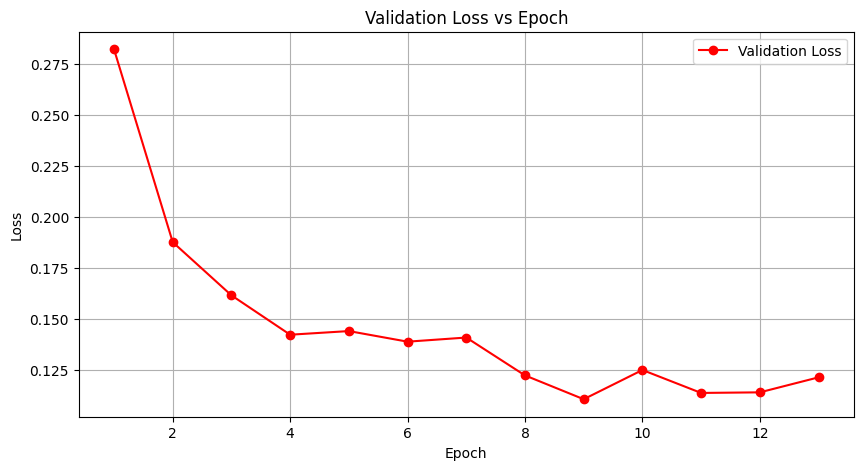

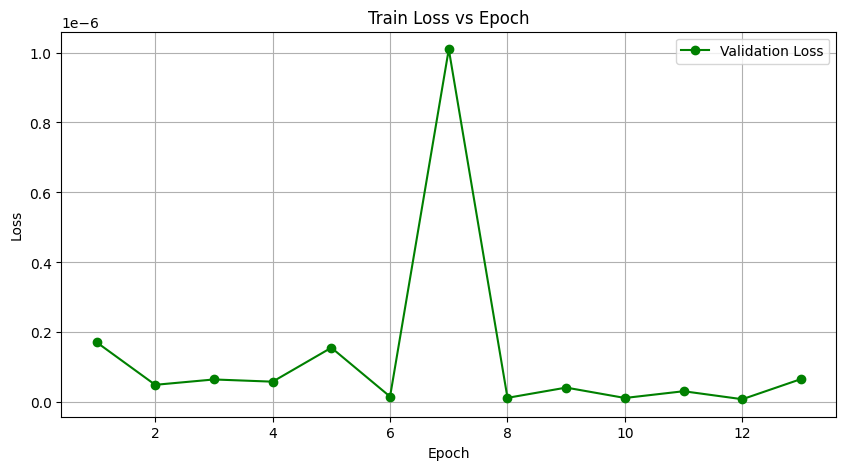

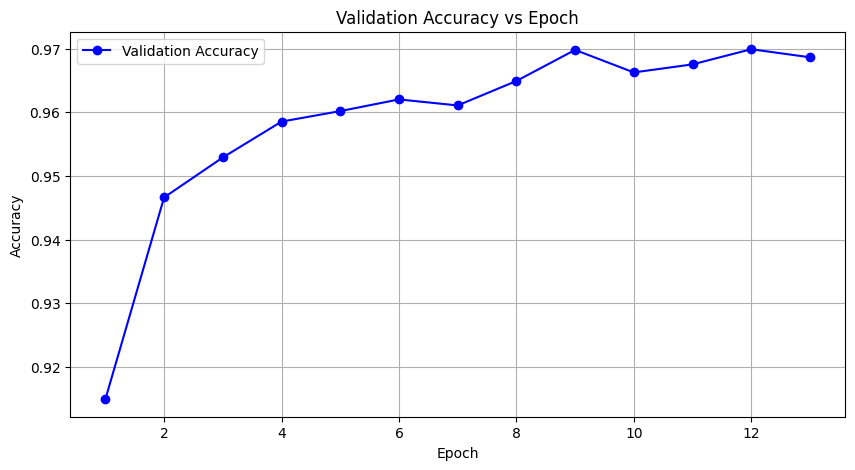

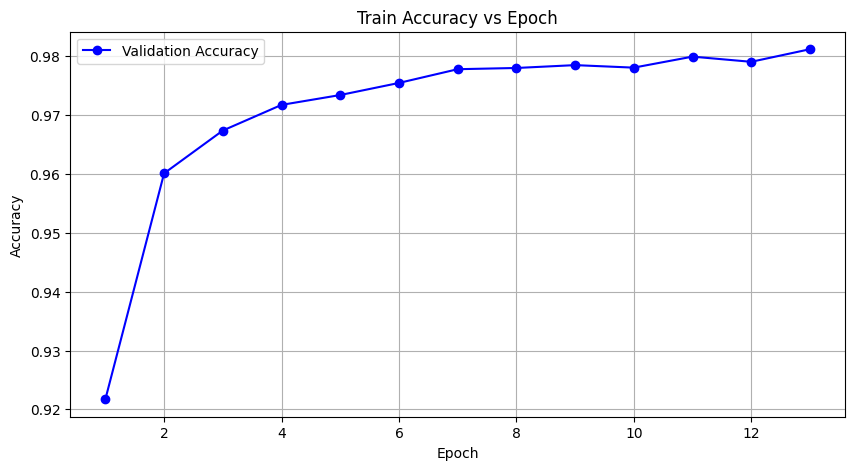

In [23]:
plot_graphs(epoch_v,valid_loss,train_loss,valid_accuracy,train_accuracy)

In [24]:
model.eval()
torch.save(model.state_dict(), 'lstm_model.pt')


In [25]:
def test_model(model,X_test_final,Y_test_final):
  test_accuracy=0
  test_pred_tags=[]
  with torch.no_grad():
    for input_test, targets_test in zip(X_test_final,Y_test_final):
      input_test = torch.tensor(input_test, dtype=torch.long)
      targets_test = torch.tensor(targets_test, dtype=torch.long)

      model.zero_grad()
      tag_scores_test = model(input_test)

      _, indices_teat = torch.max(tag_scores_test, 1)
      test_pred_tags.append(indices_teat.tolist())
      test_accuracy = test_accuracy+calc_correct(targets_test,indices_teat)
    print(f"Test accuracy: {test_accuracy/len(mod_test_data)}")

    return test_pred_tags

test_pred_tags=test_model(model,X_test_final,Y_test_final)

Test accuracy: 0.980192209154055


Info on test data

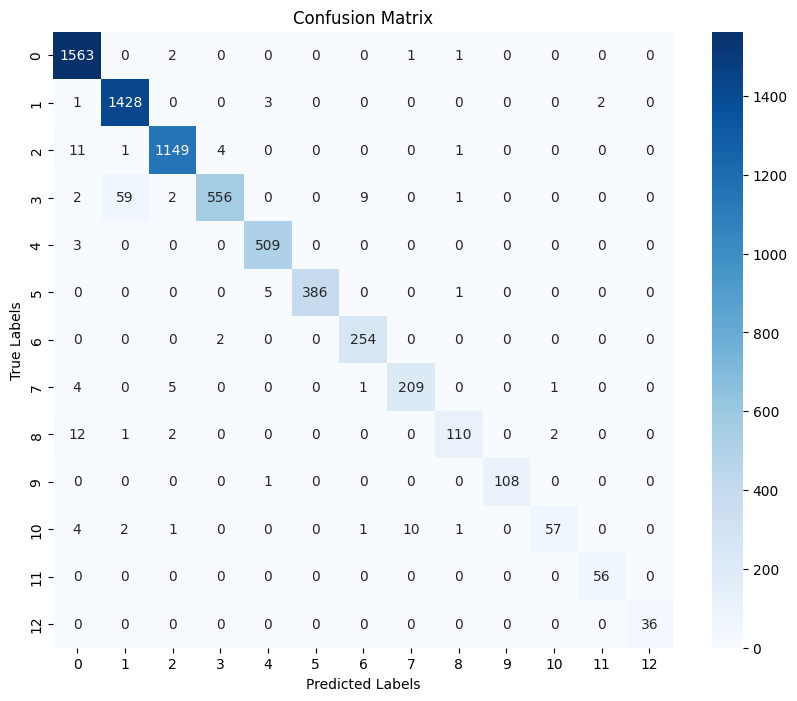

Classification Report in Color:


,precision,recall,f1-score,support
0,0.976875,0.997447,0.987054,1567.000000
1,0.957746,0.995816,0.976410,1434.000000
2,0.989664,0.985420,0.987538,1166.000000
3,0.989324,0.883943,0.933669,629.000000
4,0.982625,0.994141,0.988350,512.000000
5,1.000000,0.984694,0.992288,392.000000
6,0.958491,0.992188,0.975048,256.000000
7,0.950000,0.950000,0.950000,220.000000
8,0.956522,0.866142,0.909091,127.000000
9,1.000000,0.990826,0.995392,109.000000


In [26]:



def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]
def draw_mat(y_test_tensor, pred_vector):
  conf_matrix = confusion_matrix(flatten_list(y_test_tensor), flatten_list(pred_vector))

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()
  print("Classification Report in Color:")
  report = classification_report(flatten_list(y_test_tensor), flatten_list(pred_vector), output_dict=True)
  df = pd.DataFrame(report).transpose()
  cm = sns.light_palette("green", as_cmap=True)
  styled_table = df.style.background_gradient(cmap=cm)
  return styled_table,conf_matrix
result,conf_matrix=draw_mat(Y_test_final,test_pred_tags)

result

In [27]:
reverse_tag_vocab = {v: k for k, v in tag_vocab.get_stoi().items()}




def calculate_ans_print_class_accuracy(confusion_matrix):
    diagonal = confusion_matrix.diagonal()
    class_totals = confusion_matrix.sum(axis=1)
    class_accuracy = np.nan_to_num(diagonal / class_totals)
    class_accuracy_data = [{"Class": reverse_tag_vocab[class_idx], "Accuracy": accuracy} for class_idx, accuracy in enumerate(class_accuracy)]
    class_accuracy_df = pd.DataFrame(class_accuracy_data)
    print("class wise accuracy on test data")
    print(class_accuracy_df)

calculate_ans_print_class_accuracy(conf_matrix)


class wise accuracy on test data
    Class  Accuracy
0   PROPN  0.997447
1     ADP  0.995816
2    NOUN  0.985420
3    VERB  0.883943
4     DET  0.994141
5    PRON  0.984694
6     AUX  0.992188
7     ADJ  0.950000
8     NUM  0.866142
9   CCONJ  0.990826
10    ADV  0.750000
11   PART  1.000000
12   INTJ  1.000000


In [28]:
def find_result(user_input_tensor,model,tag_vocab):
  mapped_tags=[]

  with torch.no_grad():
    model.zero_grad()
    tag_scores_test = model(user_input_tensor)
    _, ans1 = torch.max(tag_scores_test, 1)

    tag_mapping = {index: tag for tag, index in  tag_vocab.get_stoi().items()}

    mapped_tags = [tag_mapping[idx.item()] for idx in ans1]
  return mapped_tags


In [29]:
user_input1 ="An apple a day keeps the doctor away"
print("Your Sent:", user_input1)
input= user_input1.lower().split()
original_input=input
input_encoded=sequence_to_idx_user(original_input,word_vocab)
user_input_tensor = torch.tensor(input_encoded,dtype=torch.long)
ans=find_result(user_input_tensor,model,tag_vocab)
print(ans)

Your Sent: An apple a day keeps the doctor away
['DET', 'NOUN', 'DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'PROPN']


In [30]:
ans

['DET', 'NOUN', 'DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'PROPN']